In [65]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

plt.rcParams.update({
    "font.size": 14,           # base font size
    "axes.titlesize": 14,      # title font
    "axes.labelsize": 14,      # x/y label font
    "xtick.labelsize": 14,     # x-axis tick font
    "ytick.labelsize": 14,     # y-axis tick font
    "legend.fontsize": 14
})

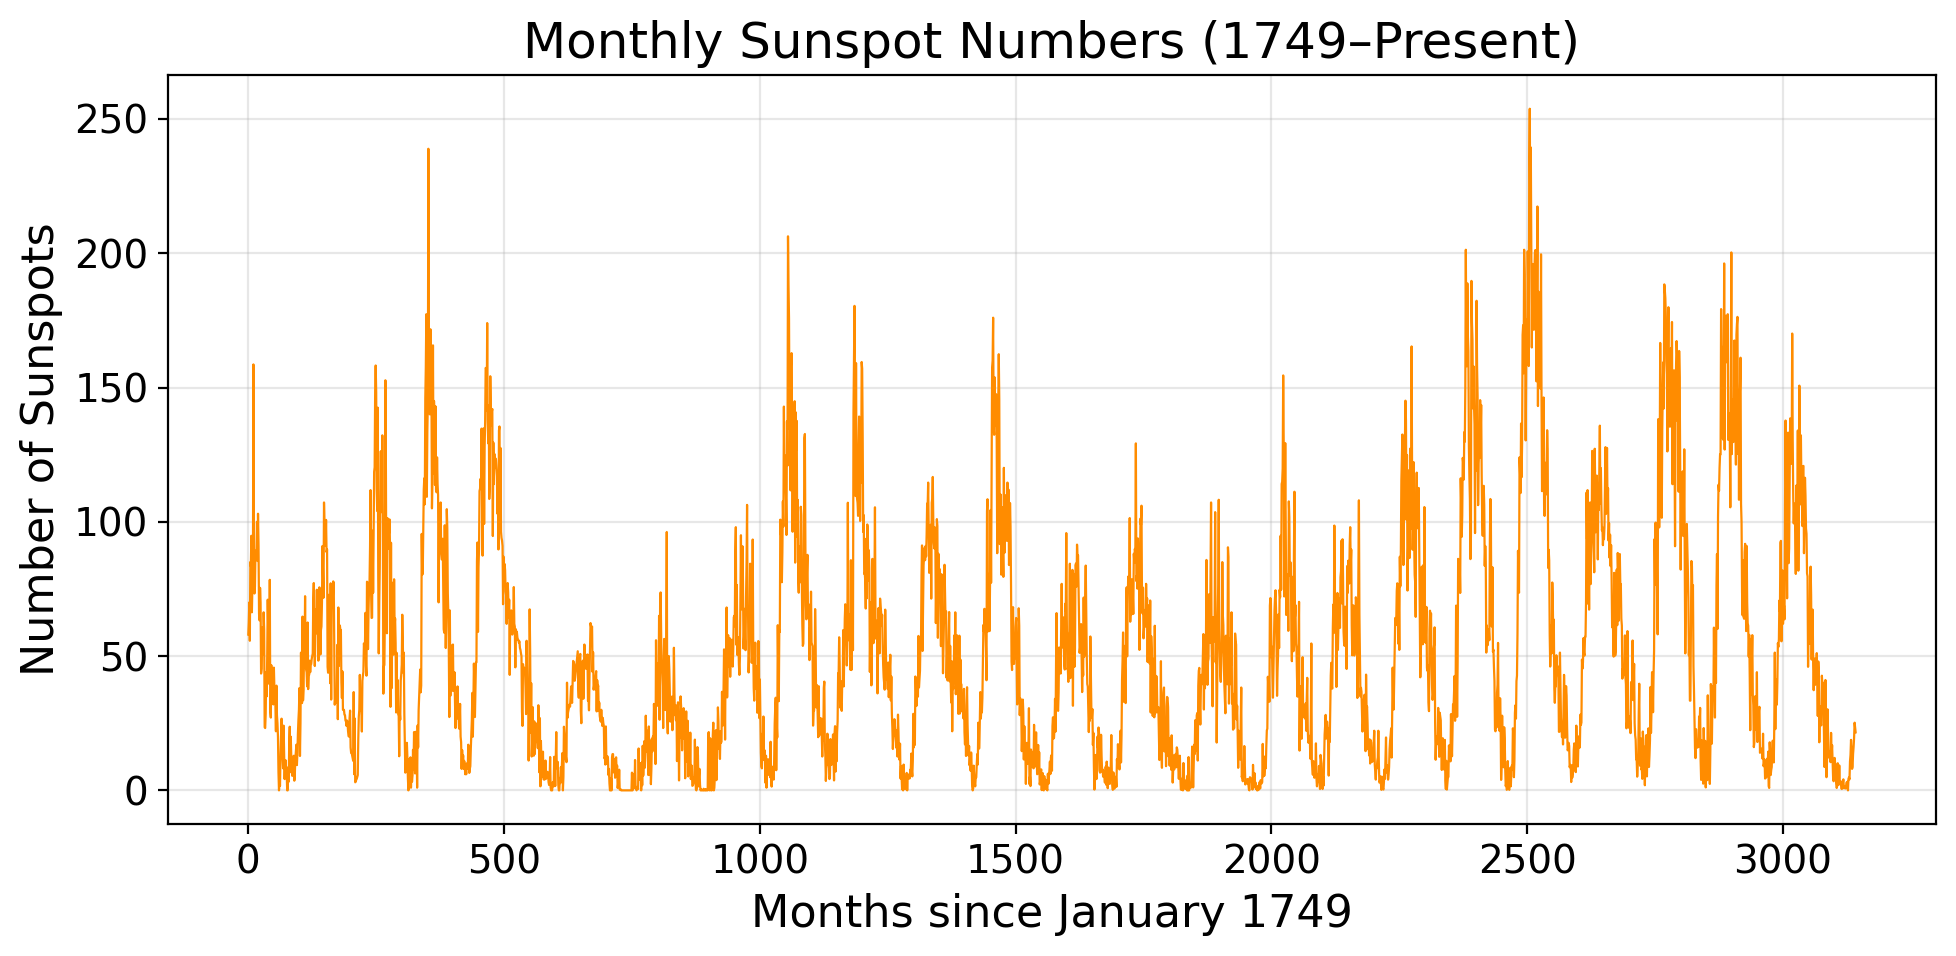

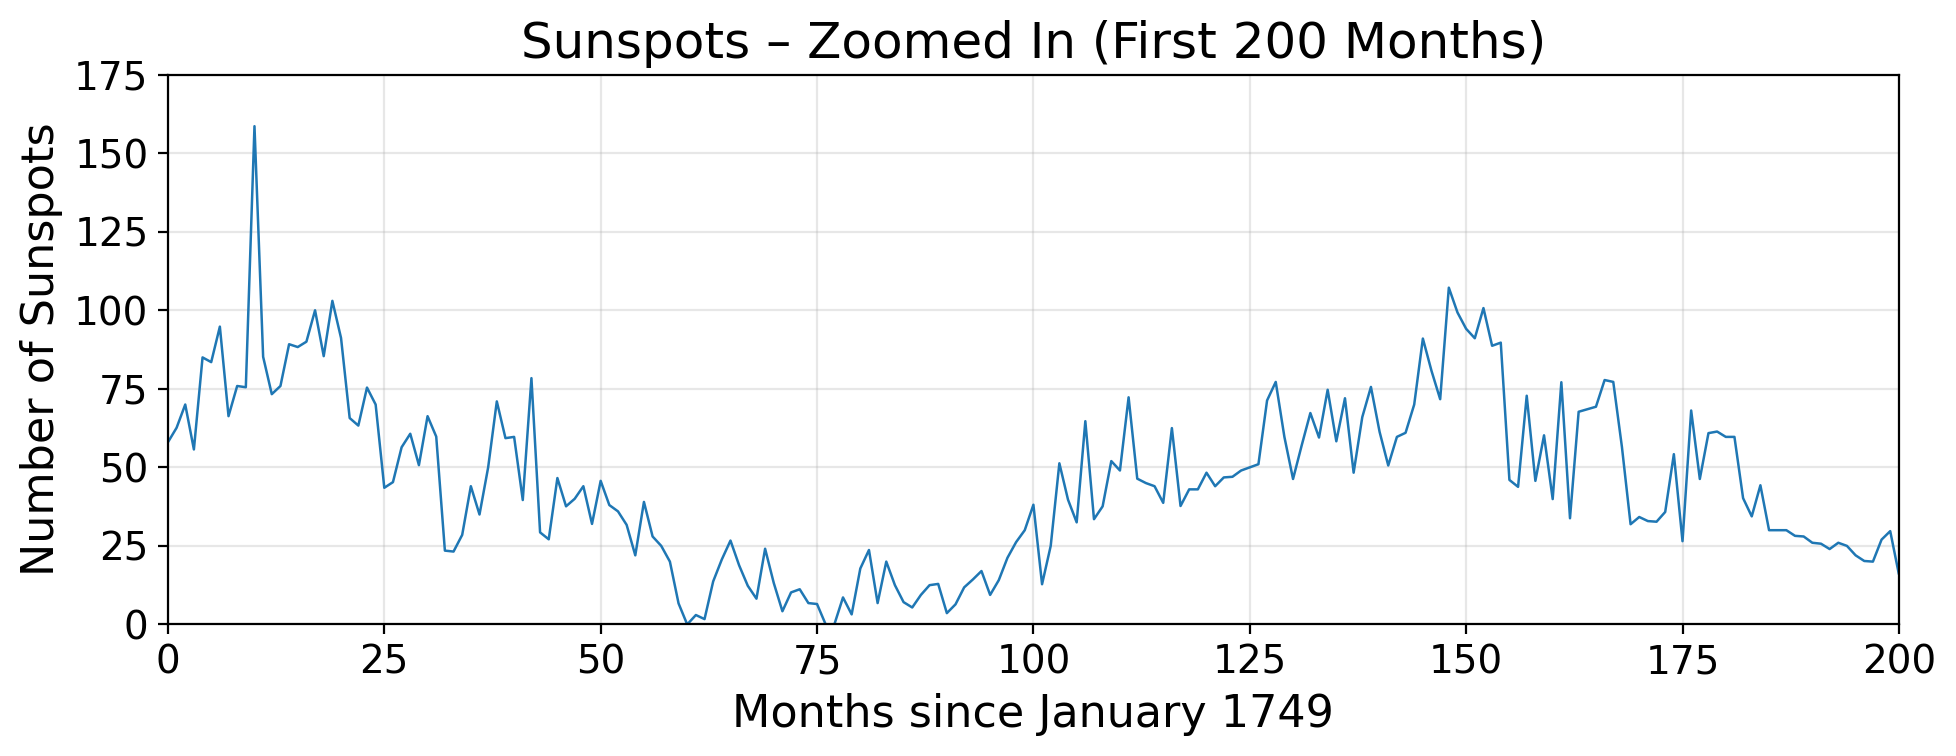

In [109]:
### Problem 1

data = np.genfromtxt("sunspots.txt")
months = data[:,0]
spots = data[:,1]

plt.figure(figsize=(10, 5), dpi=200)
plt.plot(months, spots, color='darkorange', linewidth=0.8)
plt.title("Monthly Sunspot Numbers (1749–Present)", fontsize=18)
plt.xlabel("Months since January 1749", fontsize=16)
plt.ylabel("Number of Sunspots", fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/sunspots.png")
#zoom in
plt.figure(figsize=(10, 4), dpi=200)
plt.plot(months, spots, color='tab:blue', linewidth=0.9)
plt.title("Sunspots – Zoomed In (First 200 Months)", fontsize=18)
plt.xlabel("Months since January 1749", fontsize=16)
plt.ylabel("Number of Sunspots", fontsize=16)
plt.xlim(0, 200)
plt.ylim(0,175)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/sunspotszoomed.png")
## from plot we estimate period to be around 130 months.

Dominant frequency: 0.007636016544702513
Period (months): 130.95833333333334


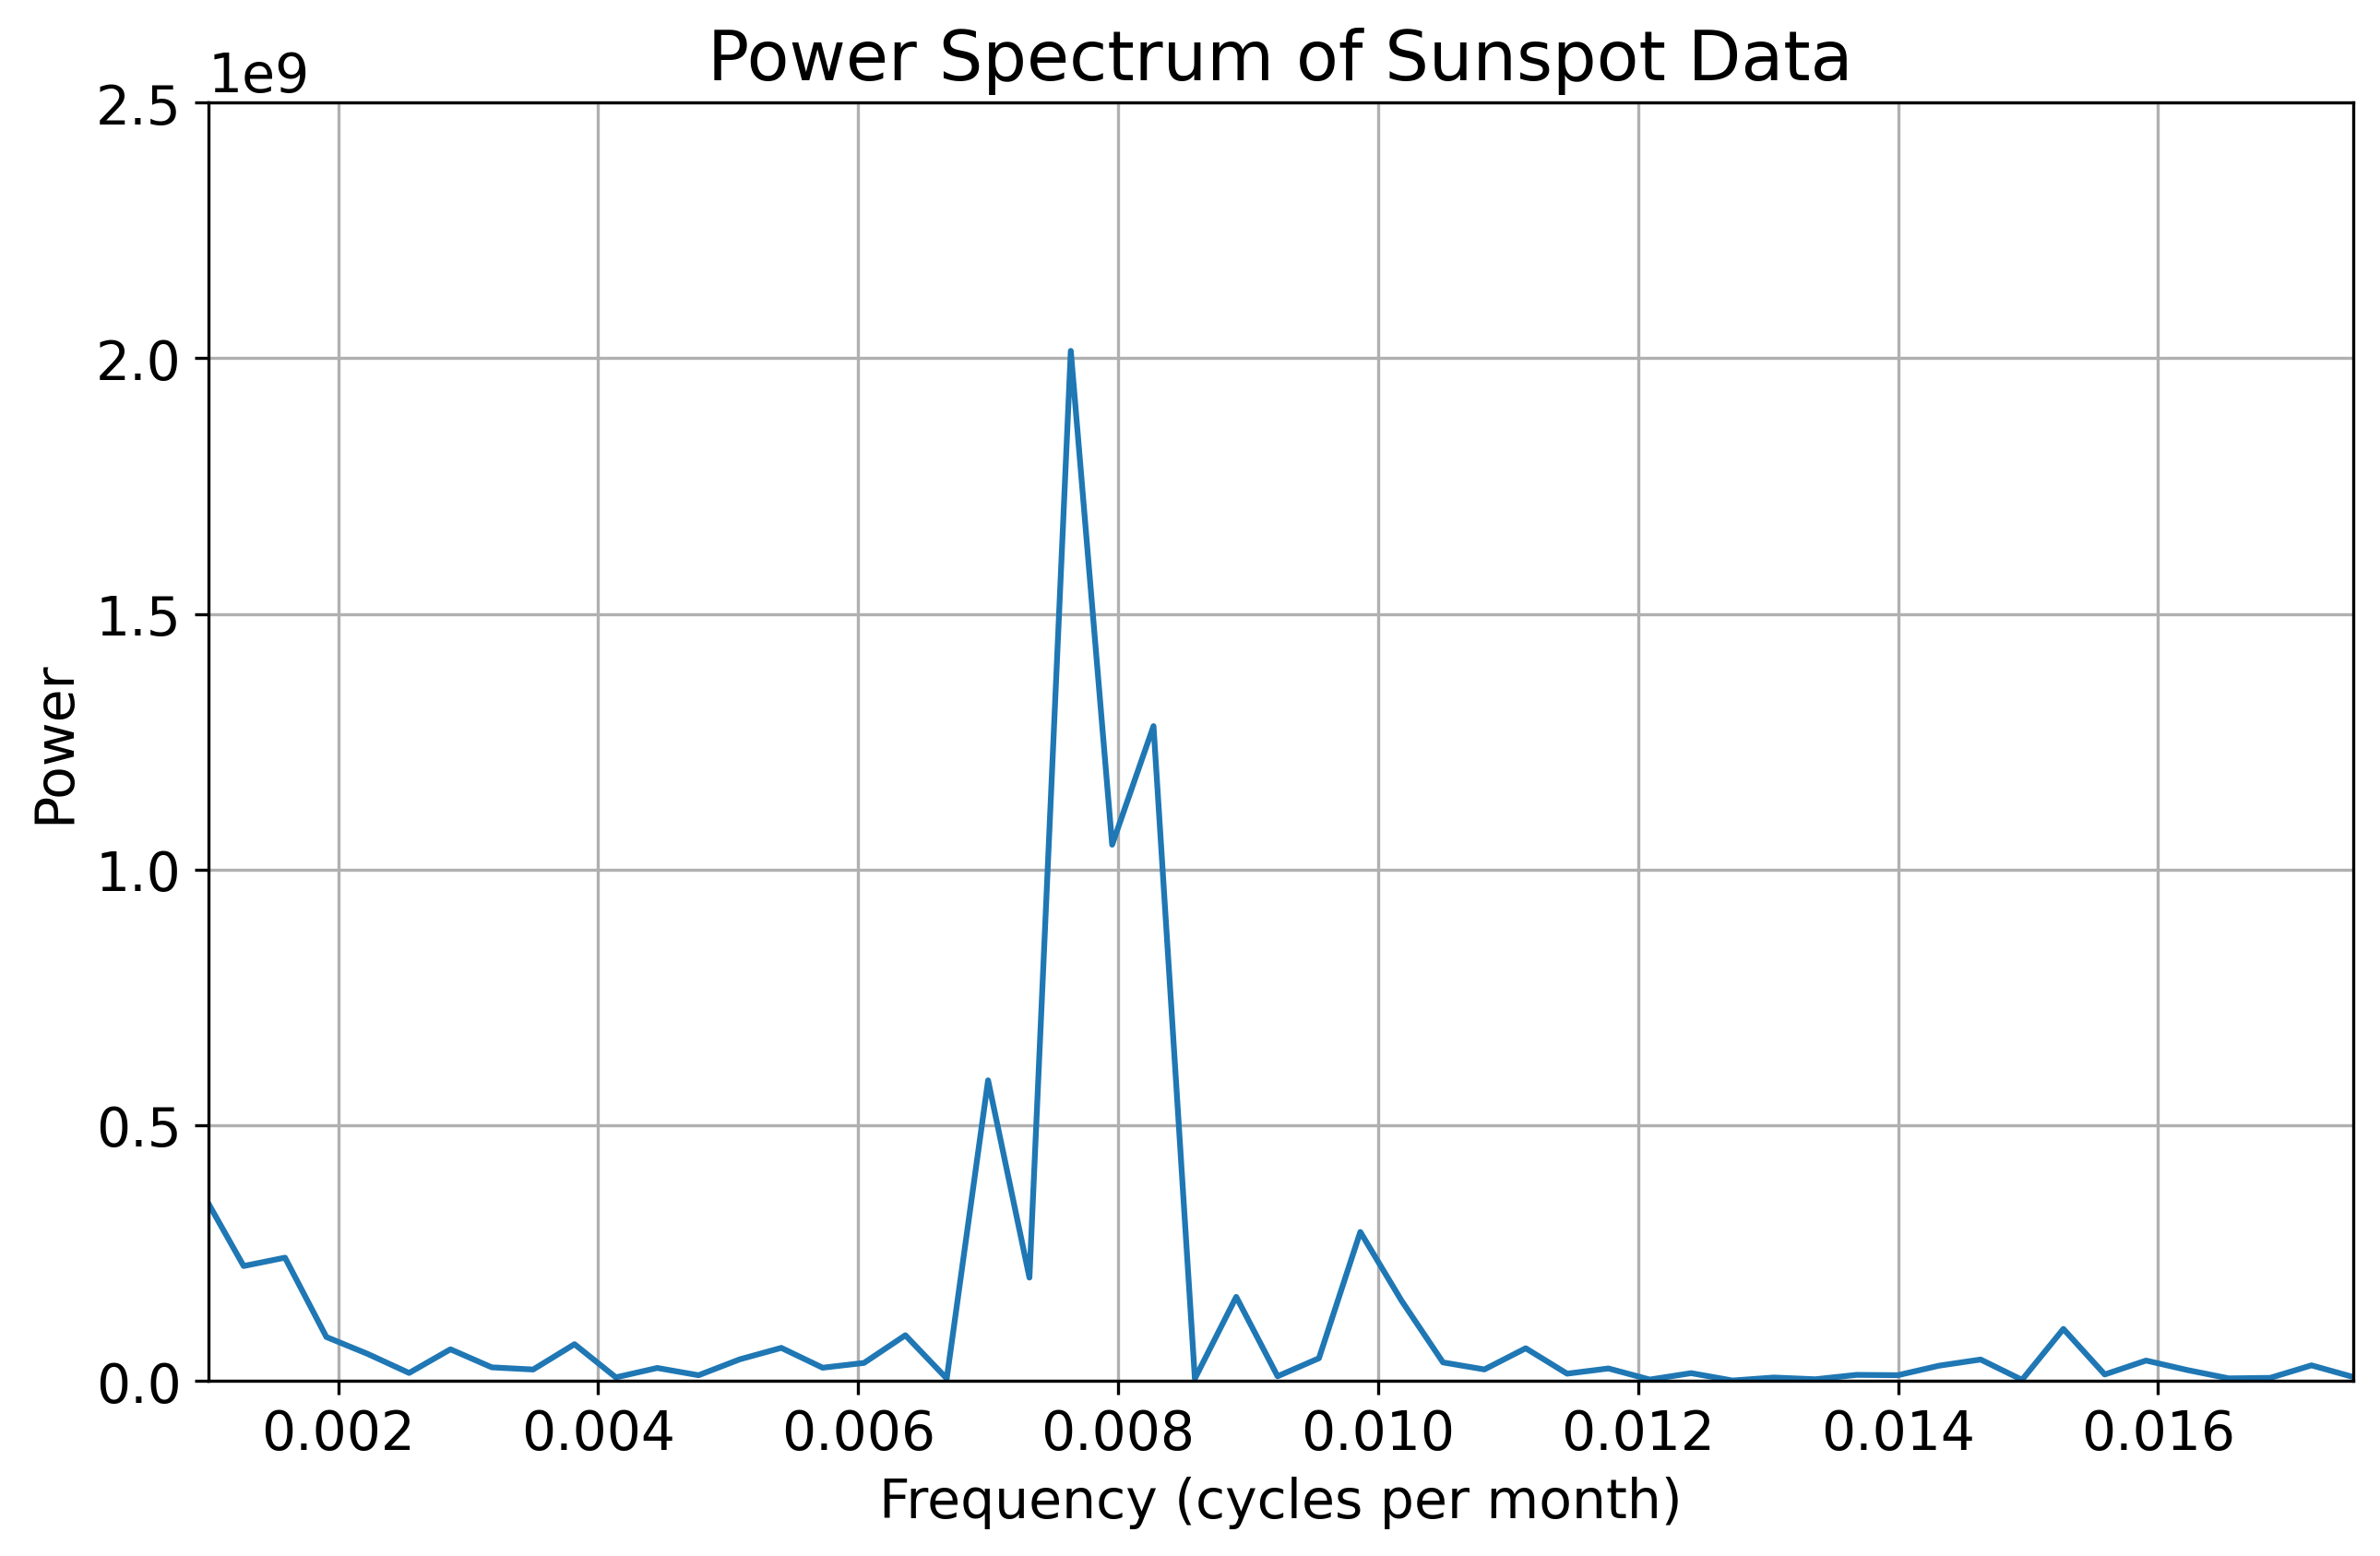

In [110]:
# do FFT
N = len(spots)
d = months[1] - months[0]   # sample spacing (≈ 1 month)
cs = np.fft.fft(spots)
freq = np.fft.fftfreq(N, d=d)
shifted_fft = np.fft.fftshift(cs)
freq_shifted = np.fft.fftshift(freq)
power = np.abs(shifted_fft)**2

plt.figure(figsize=(10,6), dpi=300)
plt.plot(freq_shifted, power)
plt.title("Power Spectrum of Sunspot Data",fontsize=18)
plt.xlabel("Frequency (cycles per month)")
plt.ylabel("Power")
plt.xlim(0.001, 0.0175)
plt.ylim(0,2.5e9)
plt.grid(True)
plt.savefig("figs/powerspec.png")

# find the main peak
mask = (freq_shifted > 0.001) & (freq_shifted < 0.0175)
peaks, _ = find_peaks(power[mask])
freq_peaks = freq_shifted[mask][peaks]
power_peaks = power[mask][peaks]

f_peak = freq_peaks[np.argmax(power_peaks)]
period = 1 / f_peak
print("Dominant frequency:", f_peak)
print("Period (months):", period)

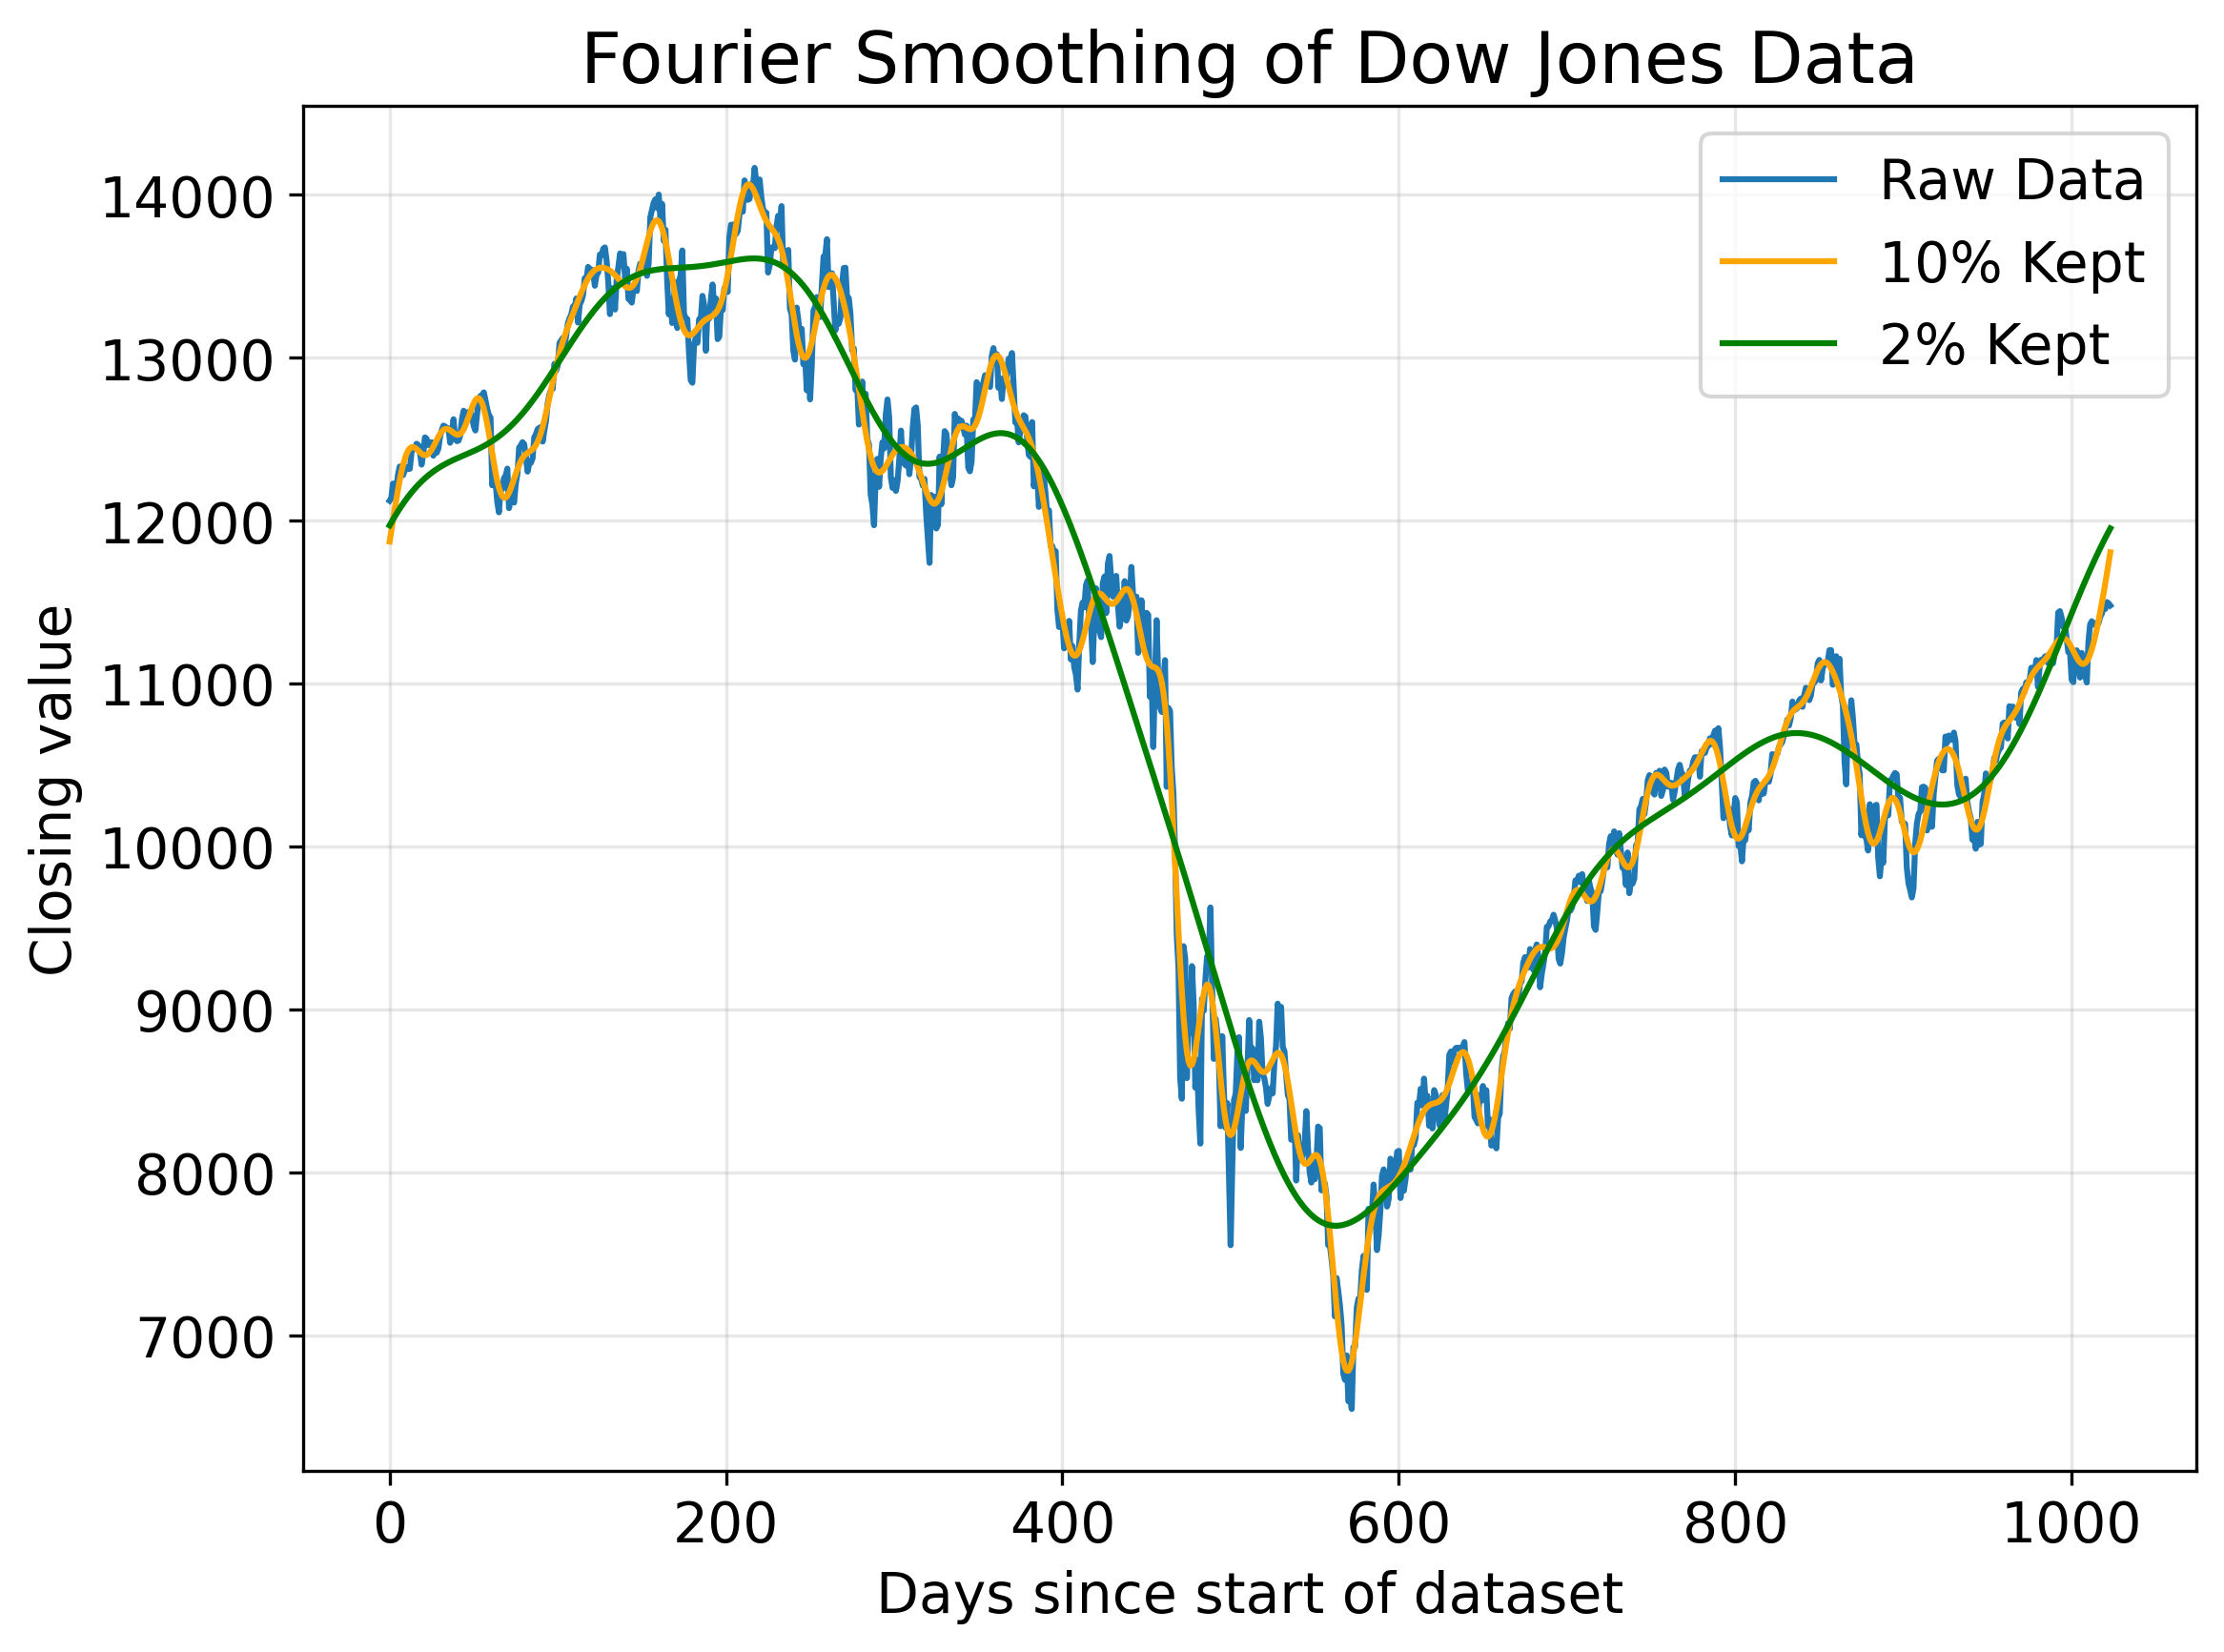

In [111]:
# Problem 2
dow = np.genfromtxt("dow.txt")
N = len(dow)
days = np.arange(N)
plt.figure(figsize=(8,6),dpi=300)
plt.plot(days,dow,label="Raw Data")
c = np.fft.rfft(dow)
M = len(c)
cutoff = int(0.1 * M)
c_filt = np.copy(c)
c_filt[cutoff:] = 0
dow_smooth = np.fft.irfft(c_filt)
plt.plot(days,dow_smooth,color='orange',label="10% Kept")
c_filt2 = np.copy(c)
cutoff2 = int(0.02 * M)
c_filt2[cutoff2:] = 0 
dow_smoother = np.fft.irfft(c_filt2)
plt.plot(days,dow_smoother,color='green',label="2% Kept")
plt.title("Fourier Smoothing of Dow Jones Data", fontsize=18)
plt.xlabel("Days since start of dataset", fontsize=14)
plt.ylabel("Closing value", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/dowjones.png")

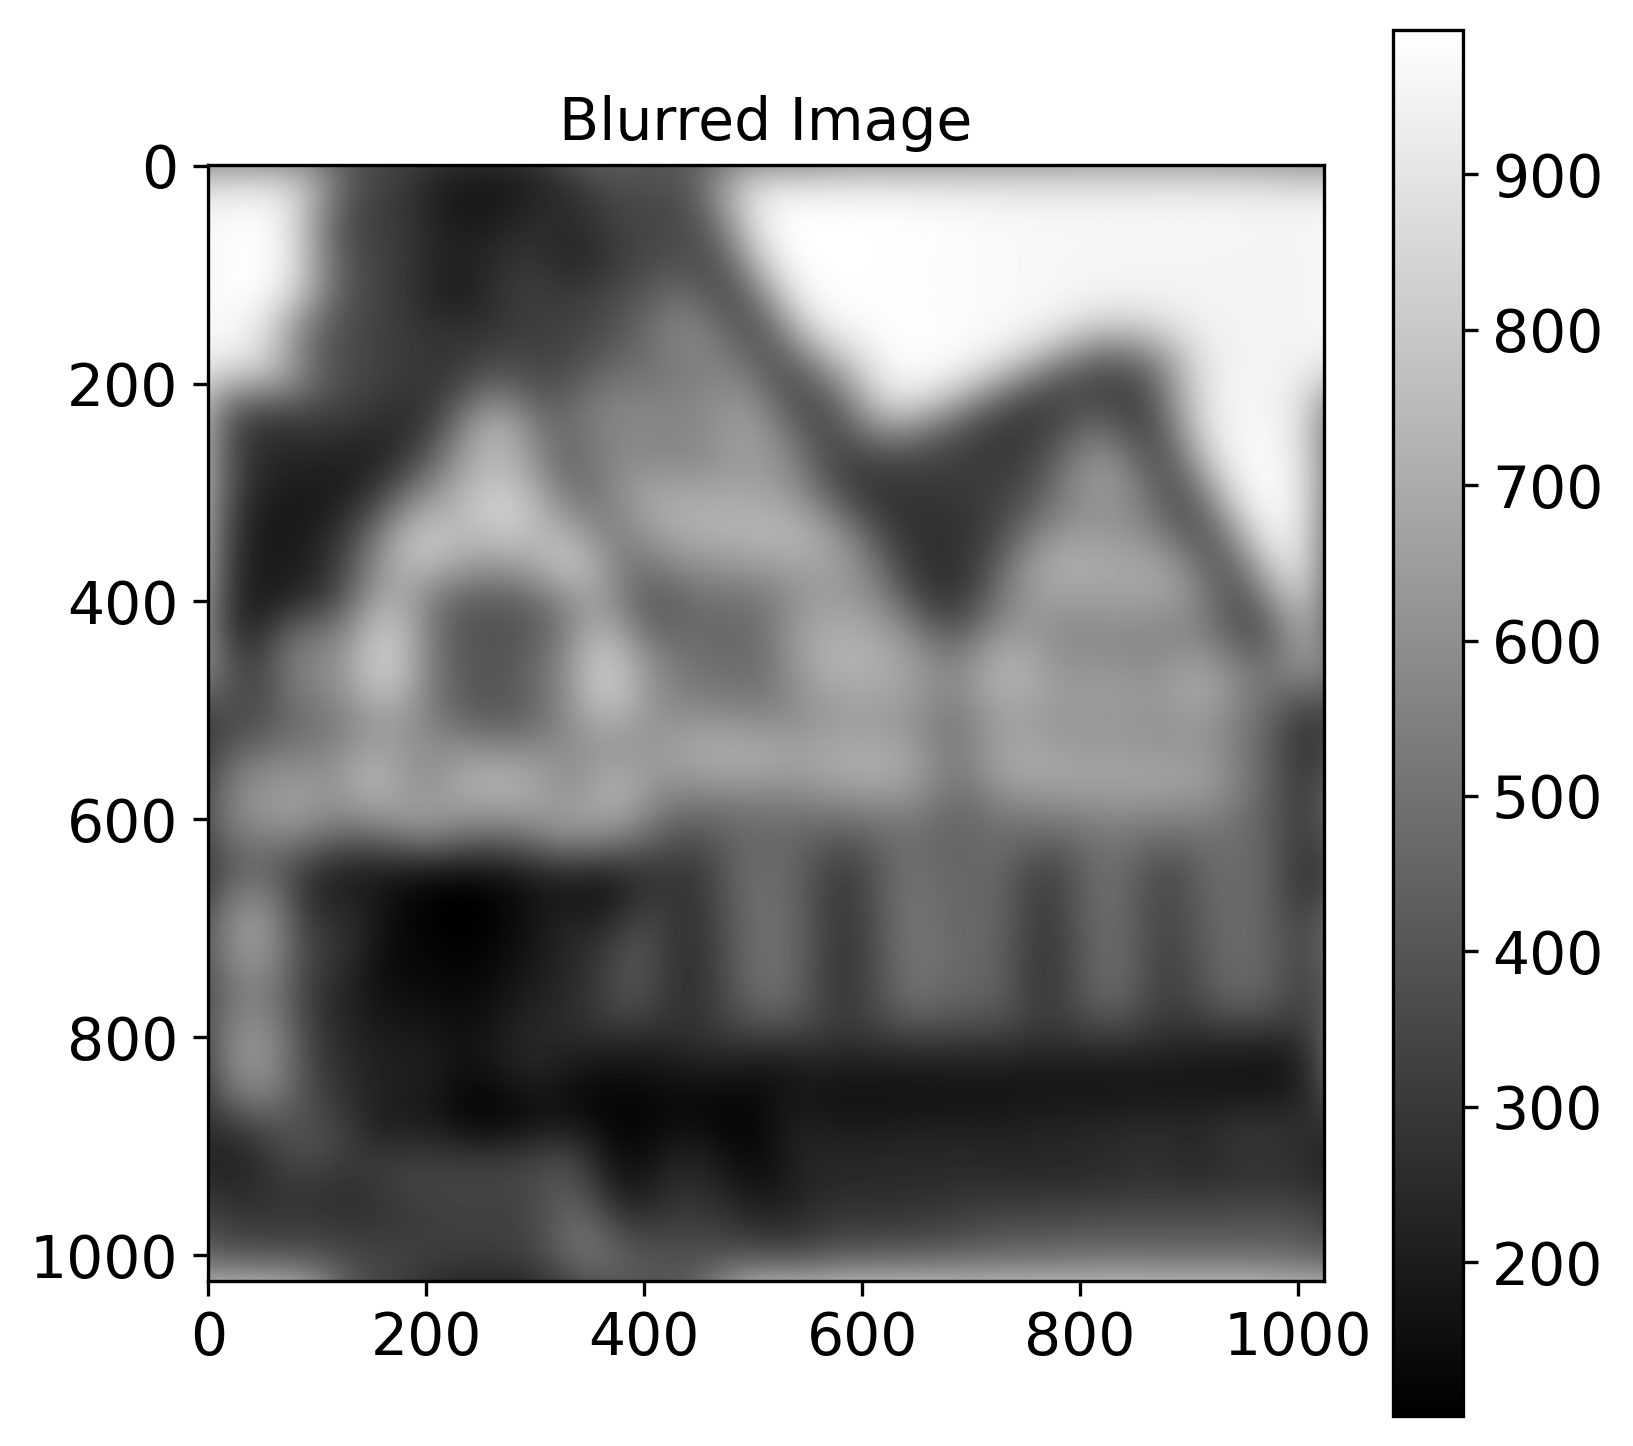

In [127]:
blur = np.genfromtxt("blur.txt")
ysize = len(blur[:,0])
xsize = len(blur[0,:])
plt.figure(figsize=(6,6),dpi=300)
plt.imshow(blur, cmap='gray', origin='upper')
plt.colorbar()
plt.title("Blurred Image")
plt.savefig("figs/blurred.png")

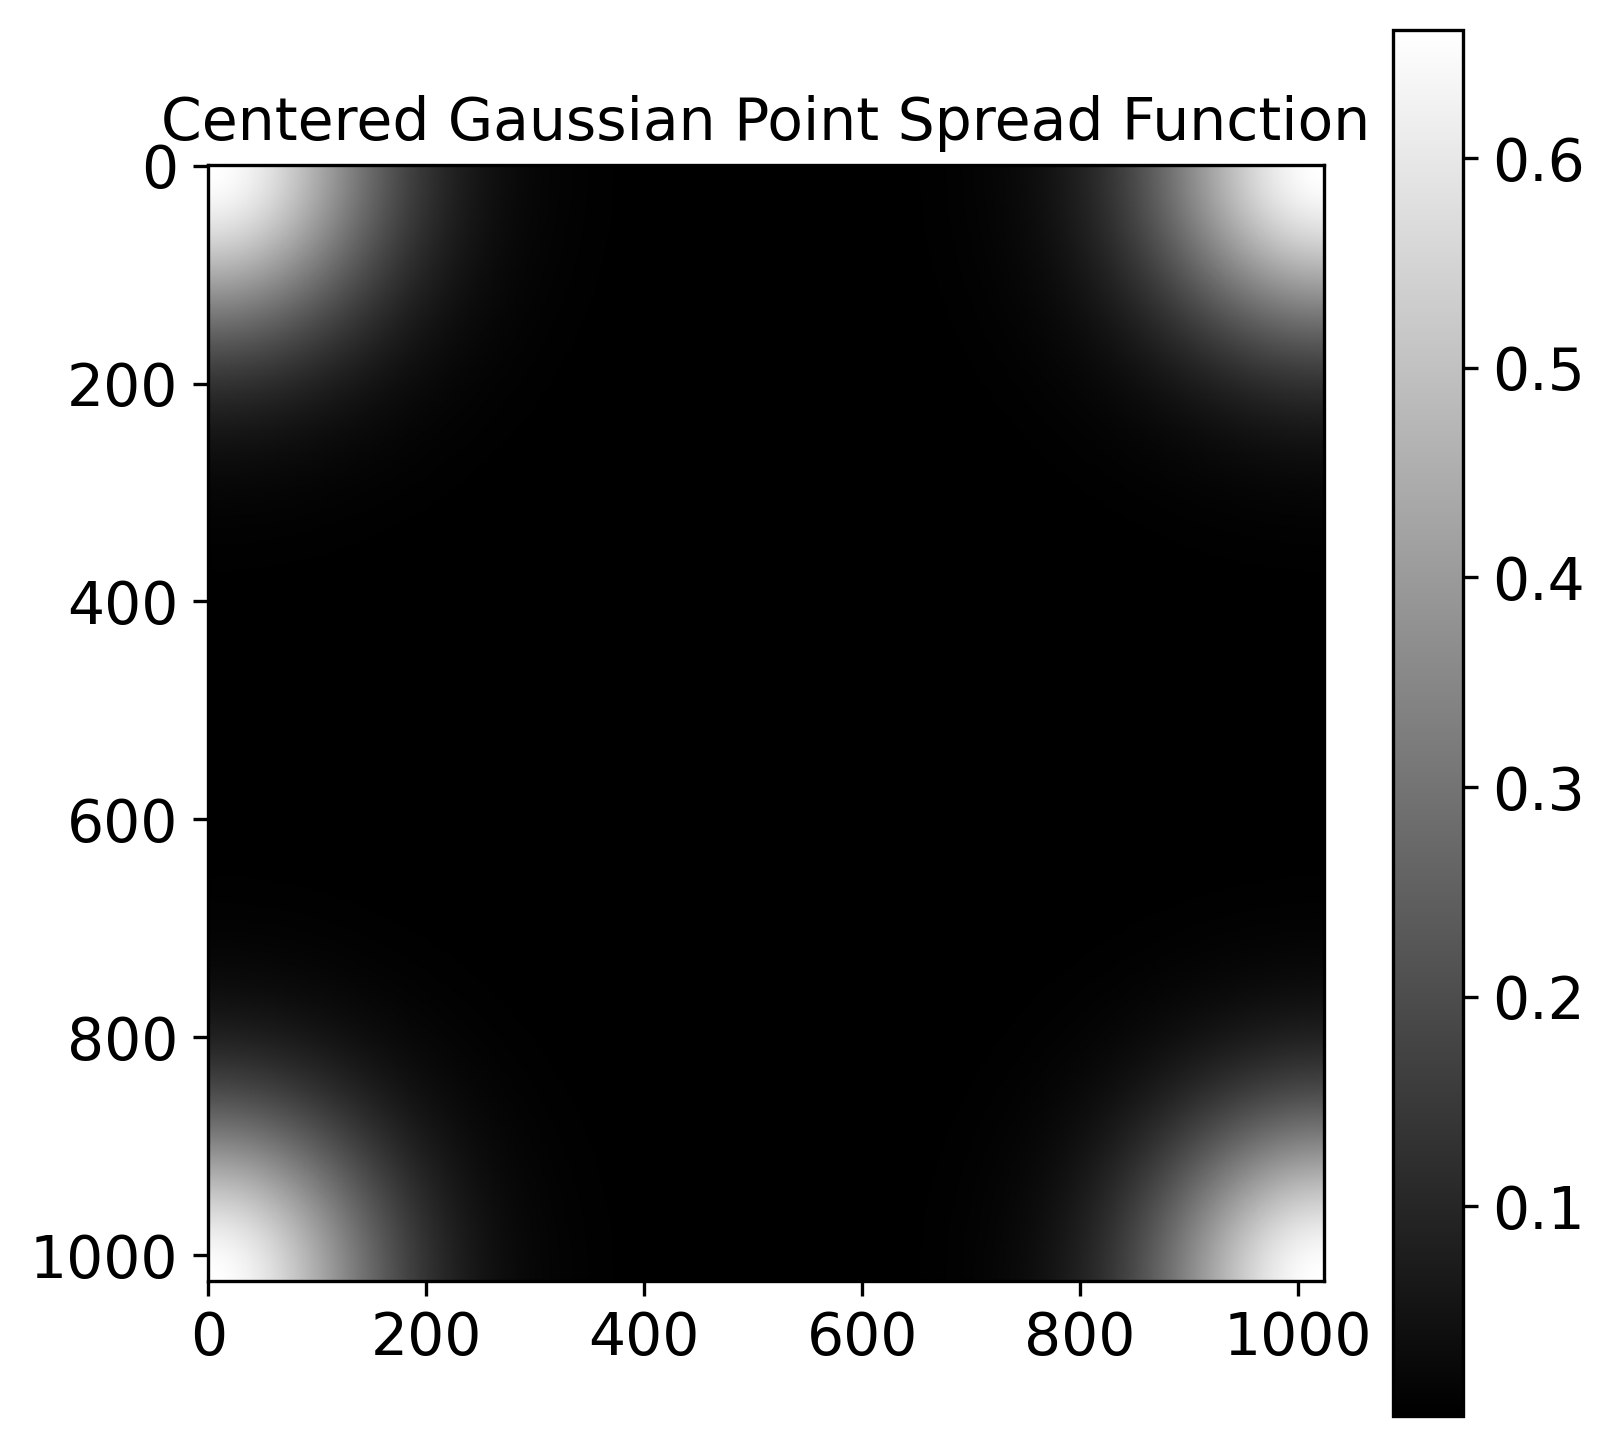

In [128]:
x = np.arange(xsize)
y  = np.arange(ysize)
X, Y = np.meshgrid(x,y,indexing='ij')

# ensure periodicity
dx = np.where(X > xsize/2, X - xsize, X)
dy = np.where(Y > ysize/2, Y - ysize, Y)

sigma=25

gaussgrid = np.exp(-(dx**2+dy**2)/(2*sigma**2))
gaussgrid = gaussgrid/np.sum(gaussgrid) #normalize

plt.figure(figsize=(6,6), dpi=300)
brightnessscale = 0.05
plt.imshow(gaussgrid**brightnessscale, cmap='gray', origin='upper')
plt.colorbar()
plt.title("Centered Gaussian Point Spread Function")
plt.savefig("figs/ptspread.png")

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]


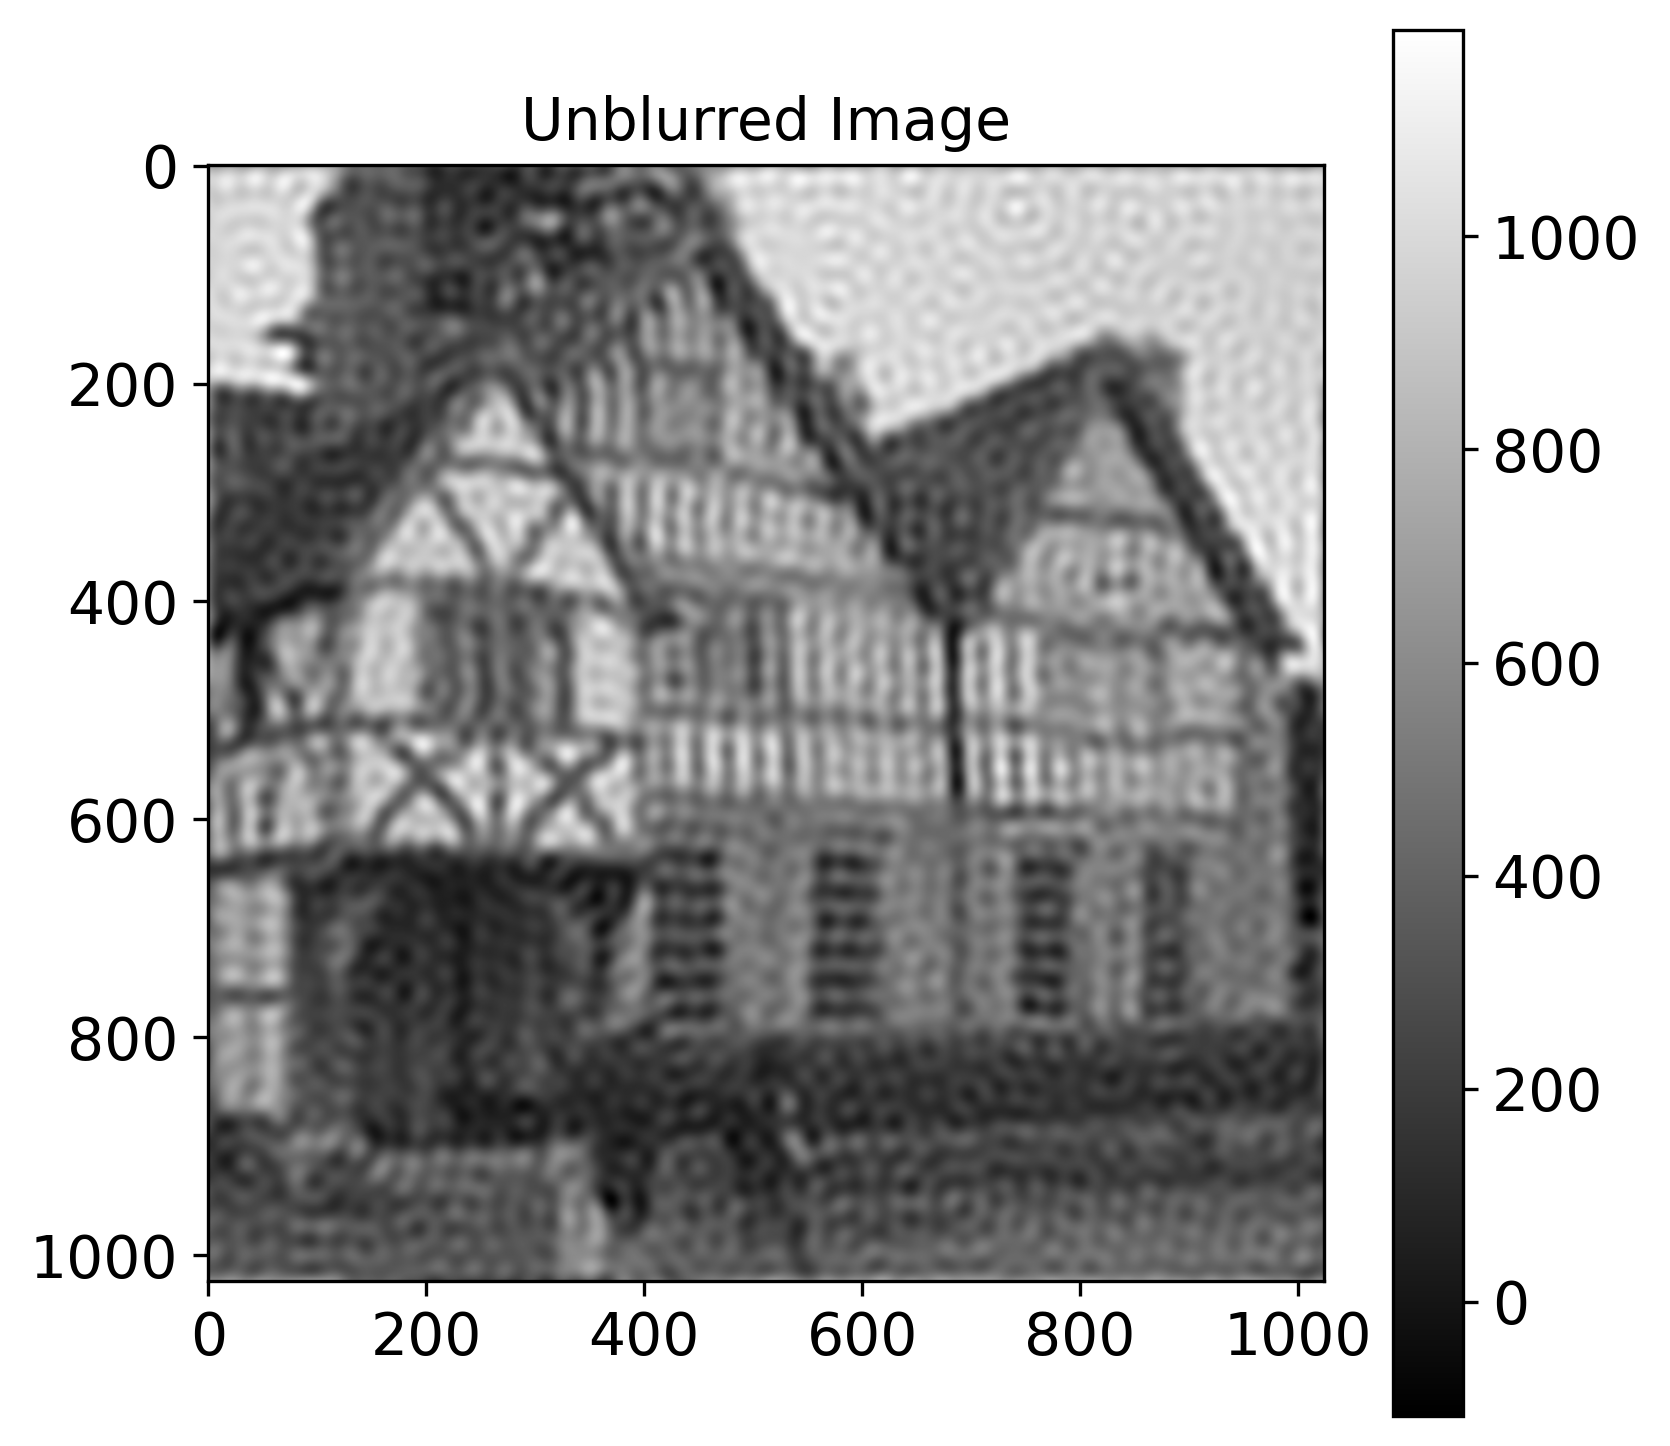

In [143]:
# make program to do deconvolution
def deconvolution(image,ptspread):
    imageft = np.fft.rfft2(image)
    ptspreadft = np.fft.rfft2(ptspread)
    tol = 1e-9
    
    ptspreadft_safe = ptspreadft.copy()
    
    # mask out very small values to avoid dividing by ~0
    small_vals = np.abs(ptspreadft_safe) < tol
    ptspreadft_safe[small_vals] = np.inf
    print(small_vals)
    
    unblurred_ft = imageft / ptspreadft_safe
    unblurred = np.fft.irfft2(unblurred_ft)

    plt.figure(figsize=(6,6), dpi=300)
    plt.imshow(unblurred, cmap='gray', origin='upper')
    plt.colorbar()
    plt.title("Unblurred Image")
    plt.show()

deconvolution(blur,gaussgrid)